#Sound Scene Classification Using KERAS

##Library install

In [0]:
%%capture
!pip install librosa
!apt-get install graphviz
!pip install graphviz 

In [0]:
%%capture
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

##import library
- os,glob : dir와 파일들에 접근하기 위한 Lib
- tensorflow, keras : 학습 및 모델 생성을 위한 Lib
- numpy : Matrix transpose 등 연산을 휘한 Lib
- librosa : feature extraction 및 음성 파일을 처리하기 위한 lib
- tqdm : iteration progress bar 생성 lib
- sklearn :scikit learn, machine learning을 지원해주는 lib

In [0]:
import os
import tensorflow as tf
import keras
import numpy as np
import librosa
import librosa.display
import glob
from tqdm import tqdm_notebook as tqdm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Using TensorFlow backend.


##Mount Google Drive
- 받아놓은 자료로부터 feature extraction을 하기 위해 Mount
- 인증해주면 마운트 완료

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##MountGoogle Drive(Cont.)
- 인증 후 자신이 저장해놓은 디렉토리를 찾기위해 ls명령어 등을 사용하여 디렉토리 위치를 확인

In [0]:
!ls '/content/drive/My Drive/Colab Notebooks/category'

chainsaw    crackling_fire  dog		rain	 sea_waves
clock_tick  crying_baby     helicopter	rooster  sneezing


- 이후 학습에 사용할 디렉토리들이 있는 상위 디렉토리의 위치를 cat_dir변수에 저장

In [0]:
cat_dir='/content/drive/My Drive/Colab Notebooks/category'

train_cat list에 cat_dir안의 모든 dir명들을 넣어줌(이경우 class label이 곧 dirname)

In [0]:
train_cat = [f for f in os.listdir(cat_dir)]

train_cat의 내용을 확인

In [0]:
train_cat

['crying_baby',
 'crackling_fire',
 'clock_tick',
 'rooster',
 'rain',
 'sea_waves',
 'chainsaw',
 'helicopter',
 'dog',
 'sneezing']

##MFCC 추출
지난 실습 시간에 했던 방식대로 MFCC를 추출해주는 함수 정의

In [0]:
def mfcc_extract(filename):
  y,sr  = librosa.load(filename,sr = 44100)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13,n_fft=int(0.02*sr),hop_length=int(0.01*sr))
  #delta=librosa.feature.delta(mfcc)
  #delta2=librosa.feature.delta(mfcc,order=2)
  #con_mfcc=np.concatenate((mfcc,delta,delta2),axis=0)
  return mfcc

parse_audio_files는 parent_dir, sub_dirs를 변수로 받음

parent_dir 아래의 sub_dirs안에서 wav파일들을 읽고 mfcc feature를 추출

In [0]:
def parse_audio_files(parent_dir, sub_dirs):
  labels = []
  features = []
  for label,sub_dir in enumerate(tqdm(sub_dirs)):
    for fn in glob.glob(os.path.join(parent_dir,sub_dir,"*.wav")):
      #print mfcc_extract(fn).shape
      features.append(mfcc_extract(fn))
      labels.append(label)
  return features,labels

##File들로부터 feature를 추출

모든 음성파일들은 5초이며 sampling rate는 44.1kHz, bit는 16bit이다. 

따라서 mfcc feature들은 한 파일당 13*501의 형태를 가지게 된다. 

In [0]:
features, labels = parse_audio_files(cat_dir,train_cat)

/usr/local/lib/python2.7/dist-packages/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)


##features 확인
features는 python기본 타입 중 하나인 list이며 (13*501) ndarray를 원소로 가지고 있음

In [0]:
print len(features), features[0].shape

400 (13, 501)


In [0]:
print type(features), type(features[0])

<type 'list'> <type 'numpy.ndarray'>


##Feature Visualization
13차 MFCC를 시각화하여 feature로 사용하기에 적합한지 확인

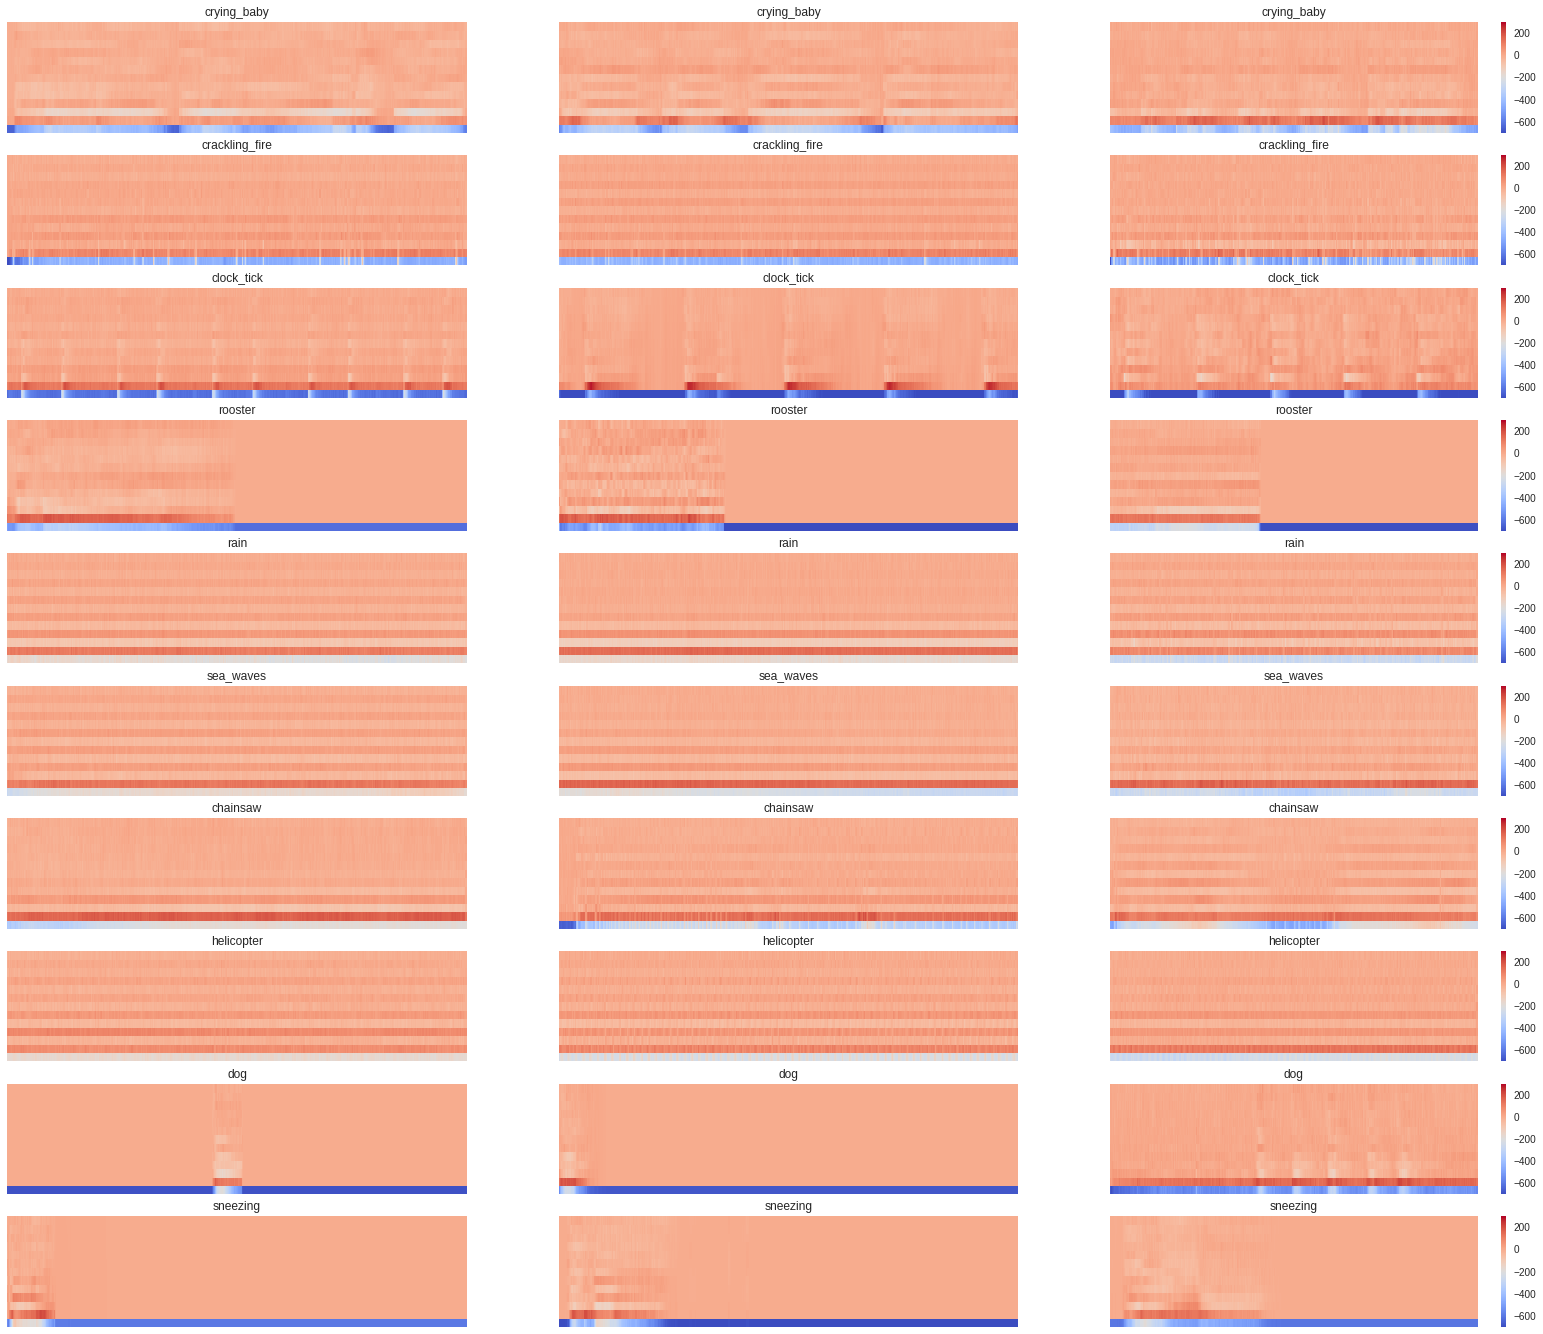

In [0]:
fig = plt.figure(figsize=(28,24))
for i,mfcc in enumerate(tqdm(features)):
  if i%40 < 3 : 
    #print i
    sub = plt.subplot(10,3,i%40+3*(i/40)+1)
    librosa.display.specshow(mfcc,vmin=-700,vmax=300)
    if ((i%40+3*(i/40)+1)%3==0) : 
      plt.colorbar()
    sub.set_title(train_cat[labels[i]])
plt.show()  

##Features를 ndarray형식으로 변환
list형식의 경우 다루기 어려워질 수 있으므로 일괄적으로 ndarray로 변환

In [0]:
features=np.asarray(features)

MNIST실습과 마찬가지로 feature들을 MLP의 INPUT에 적합한 1차원 형태로 변형시켜준다. 

In [0]:
features= features.reshape(400,13*501)
features.shape

(400, 6513)

##변형된 mfcc를 시각화

아래 코드는 각 Class별로 3개의 feature들을 시각화 하는 코드이다. 

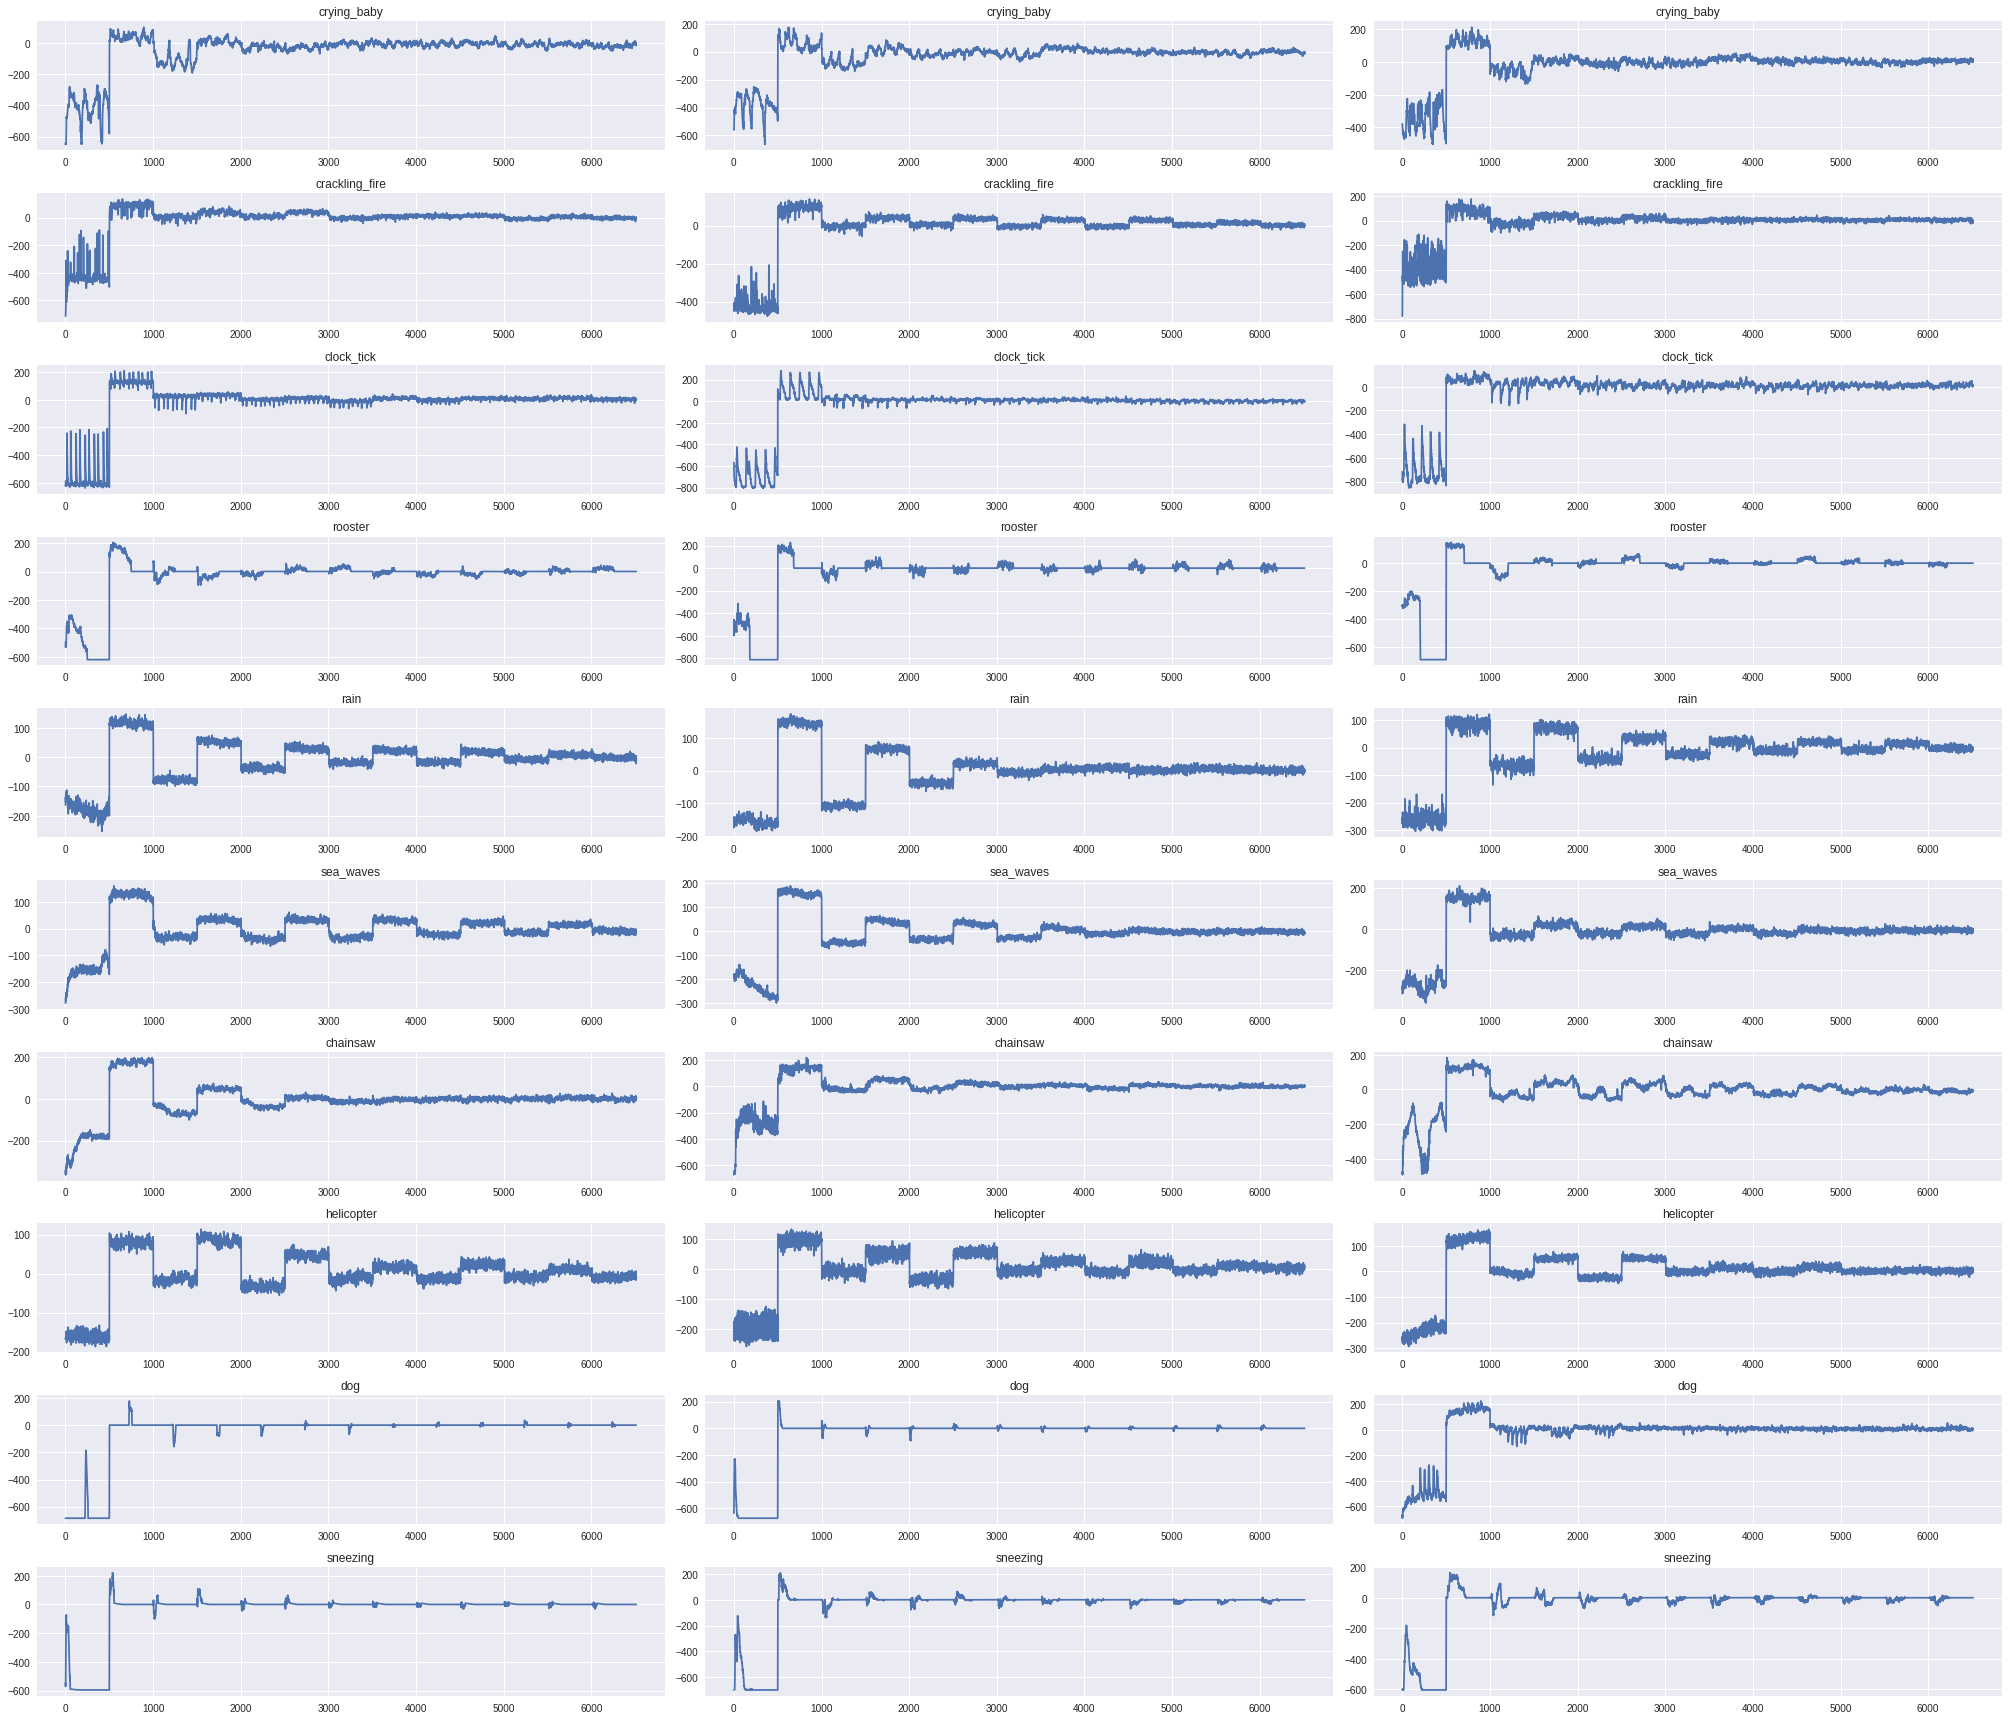

In [0]:
fig = plt.figure(figsize=(28,24))
for i,mfcc in enumerate(tqdm(features)):
  if i%40 < 3 : 
    #print i
    sub = plt.subplot(10,3,i%40+3*(i/40)+1)
    plt.plot(mfcc)
    #if ((i%40+3*(i/40)+1)%3==0) : 
      #plt.colorbar()
    sub.set_title(train_cat[labels[i]])
plt.tight_layout()
plt.show()  

##One-hot encode for Training 
학습을 위해 one-hotencoding을 진행

In [0]:
y_train = np_utils.to_categorical(labels)
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

##Shuffle Training data

현재 데이터들은 40개씩 같은 클래스의 데이터를 가지고 있다 

학습시에는 이 데이터들이 연속적으로 들어가고 하나의 클래스에 대해서만 학습될 우려가 있다.

이를 방지하기 위해 sklearn에서 지원해주는 shuffle기능을 이용하여 feature와 label을 섞어준다. 


In [0]:
features, y_train = shuffle(features, y_train, random_state=0)

##optimizer setting
lr : Learing Rate로 기본적으로 0.01임

decay : decay는 epoch마다 learing rate를 줄여주는데 사용하며 좀 더 안정적인 학습을 보장가능하다. 

###러닝레이트에 따른 error감소율

출처 :https://adbrebs.wordpress.com/2015/03/01/higher-learning-rate-and-decay/

![대체 텍스트](https://adbrebs.files.wordpress.com/2015/02/acc_comparison_lr.jpeg)

In [0]:
sgd= keras.optimizers.sgd(lr=0.01,decay=0.9)

##Build Model
모델은 다음과 같이 Hidden Layer 3층으로 구성.
activation은 여러가지를 혼용하였는데 MFCC의 값이 매우 작은 음수로 ReLU를 사용시 학습이 되지 않는 문제가 발생

1번째 Hidden Layer에서는 활성함수로 Squeeze를 위해 Sigmoid를 사용 

2번째 Hidden Layer에서는 활성함수로  PReLU(혹은 Leaky ReLU라고도 불림)를 사용[1]

3번째 Hidden Layer는 활성함수로 ReLu사용.


[1]:https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf
![대체 텍스트](https://i.stack.imgur.com/1BX7l.png)


In [0]:
model = Sequential()
model.add(Dense(units=500,input_dim=13*501,activation='sigmoid'))
model.add(Dense(units=500,input_dim=500,activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(units=500,input_dim=500,activation='relu'))
model.add(Dense(units=10,input_dim=200,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               3257000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
Total params: 3,763,010
Trainable params: 3,763,010
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


##Keras 시각화 도구를 이용한 Model 시각화

In [0]:
#import pydot
#from IPython.display import SVG
#SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))

##Model 학습

In [0]:
hist = model.fit(features,y_train,epochs=100,shuffle=True,batch_size=40)

Epoch 1/100
400/400 [==============================] - 1s 3ms/step - loss: 2.2996 - acc: 0.1650
Epoch 2/100
400/400 [==============================] - 0s 1ms/step - loss: 2.1554 - acc: 0.3300
Epoch 3/100
400/400 [==============================] - 0s 1ms/step - loss: 2.1086 - acc: 0.3975
Epoch 4/100
400/400 [==============================] - 0s 1ms/step - loss: 2.0800 - acc: 0.4700
Epoch 5/100
400/400 [==============================] - 0s 1ms/step - loss: 2.0614 - acc: 0.5150
Epoch 6/100
400/400 [==============================] - 0s 1ms/step - loss: 2.0474 - acc: 0.5400
Epoch 7/100
400/400 [==============================] - 0s 1ms/step - loss: 2.0388 - acc: 0.5625
Epoch 8/100
400/400 [==============================] - 0s 1ms/step - loss: 2.0337 - acc: 0.5450
Epoch 9/100
400/400 [==============================] - 0s 1ms/step - loss: 2.0250 - acc: 0.5625
Epoch 10/100
400/400 [==============================] - 0s 1ms/step - loss: 2.0195 - acc: 0.5675
Epoch 11/100
400/400 [=================

##학습동안 Accuracy와 Loss를 확인
Keras는 Model.fit의 결과로 history를 반환하는데 이를 이용하여 학습과정동안 문제가 없었는지 확인가능

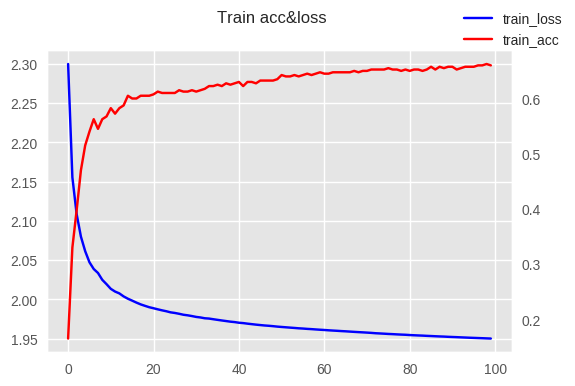

In [0]:
plt.style.use('ggplot')

fig,loss_ax =plt.subplots()
acc_ax = loss_ax.twinx()
acc_ax.grid(None)
loss_ax.plot(hist.history['loss'],'b',label='train_loss')
#loss_ax.grid(None)
acc_ax.plot(hist.history['acc'],'r',label='train_acc')
fig.set_dpi(100)
fig.suptitle('Train acc&loss')
fig.legend()
plt.show()




##Confusion Matrix
지난 시간에 배웠던 Confusion Matrix를 도식화 하기 위한 함수

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

plt.style.use('seaborn-notebook')
#plt.grid(False)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    fig = plt.figure(dpi=100,facecolor='w')
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
train_cat

['crying_baby',
 'crackling_fire',
 'clock_tick',
 'rooster',
 'rain',
 'sea_waves',
 'chainsaw',
 'helicopter',
 'dog',
 'sneezing']

##Confusion Matrix
다음과 같은 CM을 통해 Model이 어떤 Class들을 잘 구분하지 못하는지 알 수 있음

Confusion matrix, without normalization


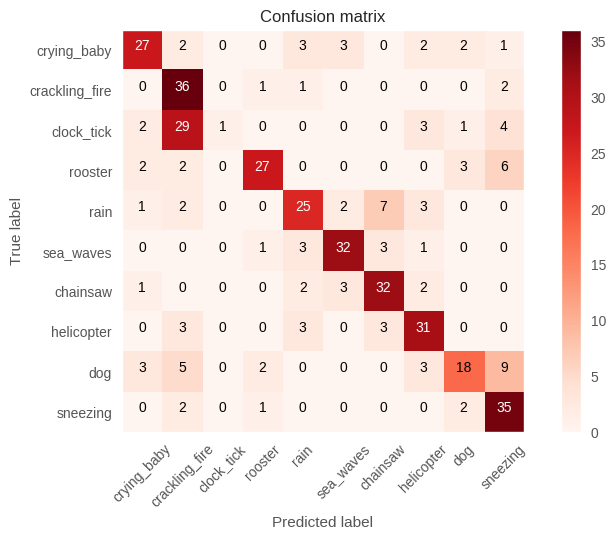

In [0]:
plot_confusion_matrix(confusion_matrix(y_train.argmax(axis=1),model.predict_classes(features)),train_cat,normalize=False)

In [0]:
#hist = model.fit(features,y_train,epochs=1000,shuffle=True,batch_size=64)

In [0]:
#plot_confusion_matrix(confusion_matrix(y_train.argmax(axis=1),model.predict_classes(features)),train_cat,normalize=False)

In [0]:
cm2 = np.asarray([[10,0,0],
           [0,5,5],
           [0,0,10]])


Confusion matrix, without normalization


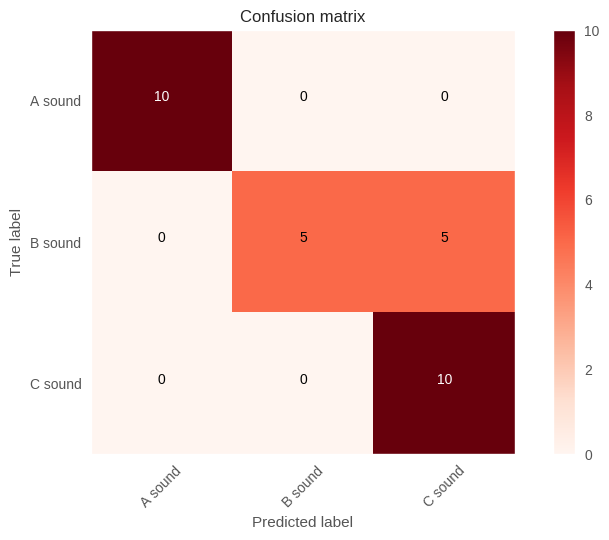

In [0]:
plot_confusion_matrix(cm2,['A sound','B sound','C sound'])